In [63]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
class CombinedStrategy(bt.Strategy):
    params = (
        ('short_window', 40),
        ('long_window', 100),
        ('rsi_period', 14),
        ('macd_fast', 12),
        ('macd_slow', 26),
        ('macd_signal', 9),
        ('initial_capital', 1000000),
        ('capital_per_trade_ratio', 0.1)
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        self.short_ma = bt.indicators.SimpleMovingAverage(self.data_close, period=self.params.short_window)
        self.long_ma = bt.indicators.SimpleMovingAverage(self.data_close, period=self.params.long_window)
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data_close, period=self.params.rsi_period)
        self.macd = bt.indicators.MACD(self.data_close,
                                       period_me1=self.params.macd_fast,
                                       period_me2=self.params.macd_slow,
                                       period_signal=self.params.macd_signal)
        self.bbands = bt.indicators.BollingerBands(self.data_close, period=20, devfactor=2)

    def next(self):
        if not self.position:  # not in the market
            if (self.short_ma[0] > self.long_ma[0] and
                self.rsi[0] < 70 and
                self.macd.macd[0] > self.macd.signal[0] and
                self.data_close[0] < self.bbands.top[0] and
                self.data_close[0] > self.bbands.mid[0]):
                # buy signal
                size = int(self.params.initial_capital * self.params.capital_per_trade_ratio / self.data_close[0])
                self.buy(size=size)
        else:  # in the market
            if self.short_ma[0] < self.long_ma[0] or self.rsi[0] > 70 or self.macd.macd[0] < self.macd.signal[0]:
                # sell signal
                self.sell(size=self.position.size)

In [4]:
def fetch_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df.index = pd.to_datetime(df.index)
    return df

[*********************100%%**********************]  1 of 1 completed


Starting Portfolio Value: 1000000.00
Ending Portfolio Value: 1042911.41
Number of trades: 24
Average return for winning trades: 4525.2114049275715
Average return for losing trades: -2774.0841437445747
Win/Loss ratio: 1.6312451859586536
Win rate: 0.625
Total profit: ₹42911.41
Sharpe Ratio: 0.57


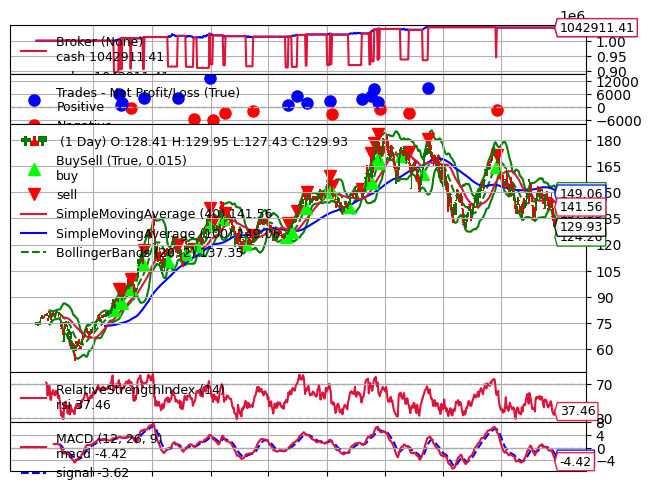

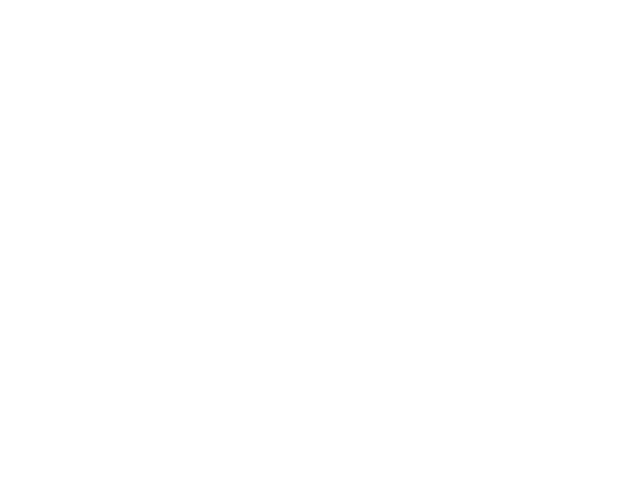

In [5]:
start_date = '2020-01-01'
end_date = '2023-01-01'
ticker = 'AAPL'

df = fetch_data(ticker, start_date, end_date)

# Ensure data is not empty
if df.empty:
    raise ValueError("No data fetched for the given date range and ticker.")

cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000)

data = bt.feeds.PandasData(dataname=df, fromdate=datetime.datetime.strptime(start_date, '%Y-%m-%d'), todate=datetime.datetime.strptime(end_date, '%Y-%m-%d'))

cerebro.adddata(data)
cerebro.addstrategy(CombinedStrategy)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

trade_analysis = strat.analyzers.trade_analyzer.get_analysis()
sharpe_ratio = strat.analyzers.sharpe_ratio.get_analysis()['sharperatio']

print(f"Number of trades: {trade_analysis['total']['closed']}")
print(f"Average return for winning trades: {trade_analysis['won']['pnl']['average']}")
print(f"Average return for losing trades: {trade_analysis['lost']['pnl']['average']}")
print(f"Win/Loss ratio: {trade_analysis['won']['pnl']['average'] / abs(trade_analysis['lost']['pnl']['average'])}")
print(f"Win rate: {trade_analysis['won']['total'] / trade_analysis['total']['closed']}")
print(f"Total profit: ₹{cerebro.broker.getvalue() - 1000000:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Save plot to file
plot_file = 'backtest_plot.png'
cerebro.plot(style='candlestick', barup='green', bardown='red', iplot=False, volume=False, tickrotation=45, fmt_x_data='%Y-%m-%d %H:%M:%S', fmt_x_ticks='%Y-%m-%d %H:%M:%S')
plt.savefig(plot_file)
plt.close()

# Display saved plot
display(Image(filename=plot_file))
